In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [27]:
# Use for conda env:tfkGPU - otherwise comment out
import tensorflow as tf
configuration = tf.compat.v1.ConfigProto()
configuration.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=configuration)

In [28]:
df = pd.read_csv('../data/cleaned_study_data/sub1_inc_clean.csv')

In [29]:
# Set 'time' as the index
df.set_index('time', inplace= True)
df.head()

Power    Oxygen  Cadence    HR    RF  session_time  hr_p_fatigue
time                                                                  
3       0.0  602.0000      0.0  86.0  16.0             0          86.0
4       0.0  578.1250      0.0  86.0  16.0             1          86.0
5       0.0  558.7500      0.0  86.0  16.0             2          86.0
6       0.0  542.1875      0.0  86.0  16.0             3          86.0
7       0.0  527.5000      0.0  86.0  16.0             4          86.0

In [30]:
# Scaling the data
mm_scaler = MinMaxScaler()
data_scaled = mm_scaler.fit_transform(df)

In [31]:
X = data_scaled
y = data_scaled[:,3] # HR is the target

In [32]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, shuffle= False, random_state = 42)

In [33]:
X_train.shape

(2264, 7)

In [34]:
X_test.shape

(567, 7)

In [35]:
y_train.shape

(2264,)

In [36]:
y_test.shape

(567,)

In [37]:
win_length = 60
batch_size= 32
num_features = 7

# Create training sequences
train_generator = TimeseriesGenerator(X_train, y_train, length= win_length, sampling_rate= 1, batch_size= batch_size )

# Create test sequences
test_generator = TimeseriesGenerator(X_test, y_test, length= win_length, sampling_rate= 1, batch_size= batch_size )

In [38]:
train_generator[0][0].shape

(32, 60, 7)

In [39]:
# LSTM Model
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape= (win_length, num_features), return_sequences= True))
model.add(tf.keras.layers.LeakyReLU(alpha= 0.5))
model.add(tf.keras.layers.LSTM(128, return_sequences= True))
model.add(tf.keras.layers.LeakyReLU(alpha= 0.5))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.LSTM(64, return_sequences= False))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1))

In [40]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 60, 128)           69632     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 60, 128)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 60, 128)           131584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 60, 128)           0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)               

In [41]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor= 'val_loss',
                                                 patience= 5,
                                                 mode= 'min')

model.compile(loss= tf.losses.MeanSquaredError(),
              optimizer= tf.optimizers.Adam()
              #metrics= [tf.metrics.MeanAbsoluteError()]
             )

history = model.fit(train_generator, epochs= 750,
                              validation_data= test_generator,
                              shuffle= False
                              #callbacks= [early_stopping]
                             )

Epoch 1/750
69/69 [==============================] - 2s 36ms/step - loss: 0.0089 - val_loss: 0.0140
Epoch 2/750
69/69 [==============================] - 1s 21ms/step - loss: 0.0089 - val_loss: 0.0239
Epoch 3/750
69/69 [==============================] - 1s 21ms/step - loss: 0.0181 - val_loss: 0.0425
Epoch 4/750
69/69 [==============================] - 1s 21ms/step - loss: 0.0089 - val_loss: 0.0270
Epoch 5/750
69/69 [==============================] - 1s 21ms/step - loss: 0.0128 - val_loss: 0.0567
Epoch 6/750
69/69 [==============================] - 1s 21ms/step - loss: 0.0082 - val_loss: 0.0494
Epoch 7/750
69/69 [==============================] - 1s 20ms/step - loss: 0.0095 - val_loss: 0.2907
Epoch 8/750
69/69 [==============================] - 1s 21ms/step - loss: 0.0086 - val_loss: 0.1827
Epoch 9/750
69/69 [==============================] - 1s 21ms/step - loss: 0.0130 - val_loss: 0.2179
Epoch 10/750
69/69 [==============================] - 1s 21ms/step - loss: 0.0085 - val_loss: 0.0135

In [42]:
train_preds = model.predict(train_generator)
test_preds = model.predict(test_generator)

In [43]:
r2_score(y_train[win_length:], train_preds), r2_score(y_test[win_length:], test_preds)

(0.9913054473325972, 0.9795329643194244)

In [44]:
plt.plot(history.history['loss'], label= 'Train')
plt.plot(history.history['val_loss'], label= 'Test')
plt.legend()
plt.ylim(0, .05);

In [45]:
hr_test_results_sc = pd.DataFrame(X_test[win_length:])

In [46]:
hr_test_results_sc[3] = test_preds

In [47]:
hr_test_results_sc.head(10)

0         1    2         3         4         5         6
0  1.0  0.951160  1.0  0.927917  0.905862  0.821201  0.075041
1  1.0  0.952089  1.0  0.925894  0.900039  0.821555  0.069284
2  1.0  0.958853  1.0  0.922613  0.903921  0.821908  0.069284
3  1.0  0.960236  1.0  0.919189  0.900039  0.822261  0.069284
4  1.0  0.959004  1.0  0.917424  0.903921  0.822615  0.069284
5  1.0  0.962721  1.0  0.917360  0.918478  0.822968  0.069284
6  1.0  0.972057  1.0  0.917435  0.941770  0.823322  0.069284
7  1.0  0.972165  1.0  0.915996  0.953416  0.823675  0.069284
8  1.0  0.967930  1.0  0.913773  0.970885  0.824028  0.069284
9  1.0  0.976077  1.0  0.911188  1.000000  0.824382  0.069284

In [48]:
# Column '3' is y_test predictions, de-scaled
hr_test_results = pd.DataFrame(mm_scaler.inverse_transform(hr_test_results_sc))
hr_test_results.head(10)

0       1     2           3      4       5     6
0  380.0  4506.6  90.0  170.331512  57.25  2324.0  76.6
1  380.0  4510.9  90.0  170.133191  56.95  2325.0  76.0
2  380.0  4542.2  90.0  169.811398  57.15  2326.0  76.0
3  380.0  4548.6  90.0  169.475689  56.95  2327.0  76.0
4  380.0  4542.9  90.0  169.302588  57.15  2328.0  76.0
5  380.0  4560.1  90.0  169.296305  57.90  2329.0  76.0
6  380.0  4603.3  90.0  169.303687  59.10  2330.0  76.0
7  380.0  4603.8  90.0  169.162575  59.70  2331.0  76.0
8  380.0  4584.2  90.0  168.944610  60.60  2332.0  76.0
9  380.0  4621.9  90.0  168.691061  62.10  2333.0  76.0

In [49]:
# This is X_test, de-scaled (Original)
df[:][-507:].reset_index()['HR'].head(10)

0    171.6
1    171.0
2    171.0
3    171.0
4    171.0
5    171.0
6    171.0
7    171.0
8    171.0
9    171.0
Name: HR, dtype: float64

In [52]:
plt.figure(figsize= (12, 5))
plt.plot(hr_test_results[3], color = 'tab:orange', label= 'HR pred')
plt.plot(df[:][-507:].reset_index()['HR'], color= 'tab:blue', label= 'HR actual')
plt.plot(df[:][-507:].reset_index()['Power'], color= 'tab:green', label= 'Power actual')
plt.legend();

In [20]:
# RNN Design

gru_model = tf.keras.Sequential()
gru_model.add(tf.keras.layers.LSTM(128, input_shape= (win_length, num_features), return_sequences= True))

gru_model.add(tf.keras.layers.LSTM(128, return_sequences= True))
gru_model.add(tf.keras.layers.LeakyReLU(alpha= 0.5))
gru_model.add(tf.keras.layers.Dropout(0.3))
gru_model.add(tf.keras.layers.LSTM(64, return_sequences= False))
gru_model.add(tf.keras.layers.Dropout(0.3))
gru_model.add(tf.keras.layers.Dense(1))

gru_model.compile(loss='mse', optimizer=Adam(lr=.0005), metrics= 'mse')

In [21]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor= 'val_loss',
                                                 patience= 30,
                                                 mode= 'min')

gru_model.compile(loss= tf.losses.MeanSquaredError(),
              optimizer= tf.optimizers.Adam()
              #metrics= [tf.metrics.MeanAbsoluteError()]
             )

gru_history = gru_model.fit(train_generator, epochs= 300,
                              validation_data= test_generator,
                              shuffle= False
                              #callbacks= [early_stopping]
                             )

Epoch 1/300
69/69 [==============================] - 2s 32ms/step - loss: 0.0101 - val_loss: 0.0279
Epoch 2/300
69/69 [==============================] - 1s 21ms/step - loss: 0.0104 - val_loss: 0.0258
Epoch 3/300
69/69 [==============================] - 1s 21ms/step - loss: 0.0153 - val_loss: 0.0965
Epoch 4/300
69/69 [==============================] - 1s 21ms/step - loss: 0.0132 - val_loss: 0.1374
Epoch 5/300
69/69 [==============================] - 2s 22ms/step - loss: 0.0082 - val_loss: 0.1095
Epoch 6/300
69/69 [==============================] - 1s 21ms/step - loss: 0.0311 - val_loss: 0.0627
Epoch 7/300
69/69 [==============================] - 1s 21ms/step - loss: 0.0079 - val_loss: 0.0644
Epoch 8/300
69/69 [==============================] - 1s 21ms/step - loss: 0.0085 - val_loss: 0.0626
Epoch 9/300
69/69 [==============================] - 1s 21ms/step - loss: 0.0084 - val_loss: 0.0393
Epoch 10/300
69/69 [==============================] - 1s 21ms/step - loss: 0.0061 - val_loss: 0.0289

In [22]:
gru_train_preds = gru_model.predict(train_generator)
gru_test_preds = gru_model.predict(test_generator)

In [23]:
r2_score(y_train[win_length:], gru_train_preds), r2_score(y_test[win_length:], gru_test_preds)

(0.937991290890204, 0.7017085685924542)

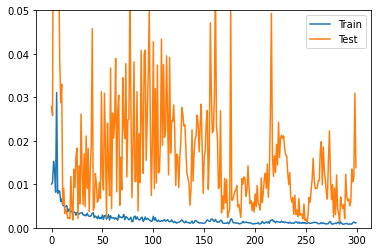

In [25]:
plt.plot(gru_history.history['loss'], label= 'Train')
plt.plot(gru_history.history['val_loss'], label= 'Test')
plt.legend()
plt.ylim(0, .05);

In [84]:
gru_train_preds_df = pd.DataFrame(gru_train_preds)
#gru_train_preds_df.head(50)

In [85]:
#pd.DataFrame(y_test[3:])

In [87]:
pd.DataFrame(mm_scaler.inverse_transform(gru_train_preds_df))

0            1          2           3          4            5  \
0     101.005600  1678.866211  77.418106  110.238457  24.101374   770.512207   
1     100.941826  1678.188354  77.434853  110.218384  24.096031   769.945435   
2     100.940239  1678.171509  77.435272  110.217896  24.095898   769.931335   
3     101.025017  1679.072876  77.413002  110.244583  24.103004   770.684937   
4     101.175774  1680.674927  77.373352  110.292030  24.115633   772.025085   
...          ...          ...        ...         ...        ...          ...   
2199  348.515228  4214.423828  89.999519  173.106979  37.904427  1937.257080   
2200  348.511383  4214.373535  89.999519  173.106339  37.903831  1937.223633   
2201  348.505737  4214.302246  89.999519  173.105423  37.903111  1937.178955   
2202  348.506134  4214.306641  89.999519  173.105515  37.903259  1937.184326   
2203  348.511536  4214.376465  89.999519  173.106400  37.904011  1937.228882   

              6  
0     88.282158  
1     88.274277  
2     88.274086  
3     88.284554  
4     88.303177  
...         ...  
2199  85.776466  
2200  85.776817  
2201  85.777306  
2202  85.777260  
2203  85.776779  

[2204 rows x 7 columns]